In [1]:
import numpy as np
import mygrad as mg
import matplotlib.pyplot as plt
import matplotlib.pylab as lab

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
data = np.load("data/songs.npz")
data_x = data["data_x"]
data_y = data["data_y"]
data_ids = data["data_id"]
mapping = data["mapping"]

In [4]:
idxs = np.random.permutation(len(data_x)) # shuffle
data_x = data_x[idxs]
data_y = data_y[idxs]

In [5]:
mean = np.mean(data_x,axis=0)
std = np.std(data_x,axis=0)
data_x = (data_x-mean)/std # normalize

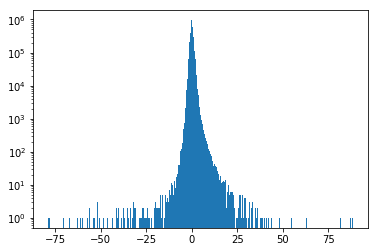

In [6]:
fig,ax = plt.subplots()
ax.hist(data_x.flatten(),bins=500);
ax.set_yscale('log')

In [7]:
print(data_y)
idxs = np.random.permutation(len(data_x))
data_x = data_x[idxs]
data_y = data_y[idxs]
split = 1000
train_x = data_x[:-split]
train_y = data_y[:-split]
test_x = data_x[-split:]
test_y = data_y[-split:]

[3 1 0 ... 6 5 2]


In [8]:
print(test_y.mean())

3.473


In [9]:
input_size = 518
output_size= 8
# DO PYTORCH INSTEAD
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout
from mynn.initializers.he_normal import he_normal
from mynn.activations.relu import relu
from functools import reduce
class NN:
    init = he_normal
    def __init__(self,layer_sizes=[518,8]):
        self.layers = []
        for i, v in enumerate(layer_sizes[:-1]): # stop at last one
            self.layers.append(dense(v,layer_sizes[i+1],weight_initializer=NN.init))
        self.dropout = dropout(0.5)
    def __call__(self,X):
        for v in self.layers[:-1]:
            X = relu(v(X))
            X = self.dropout(X)
        return self.layers[-1](X)
    
    @property
    def parameters(self):
        return reduce(lambda a,b: a+b, [layer.parameters for layer in self.layers])

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


<IPython.core.display.Javascript object>


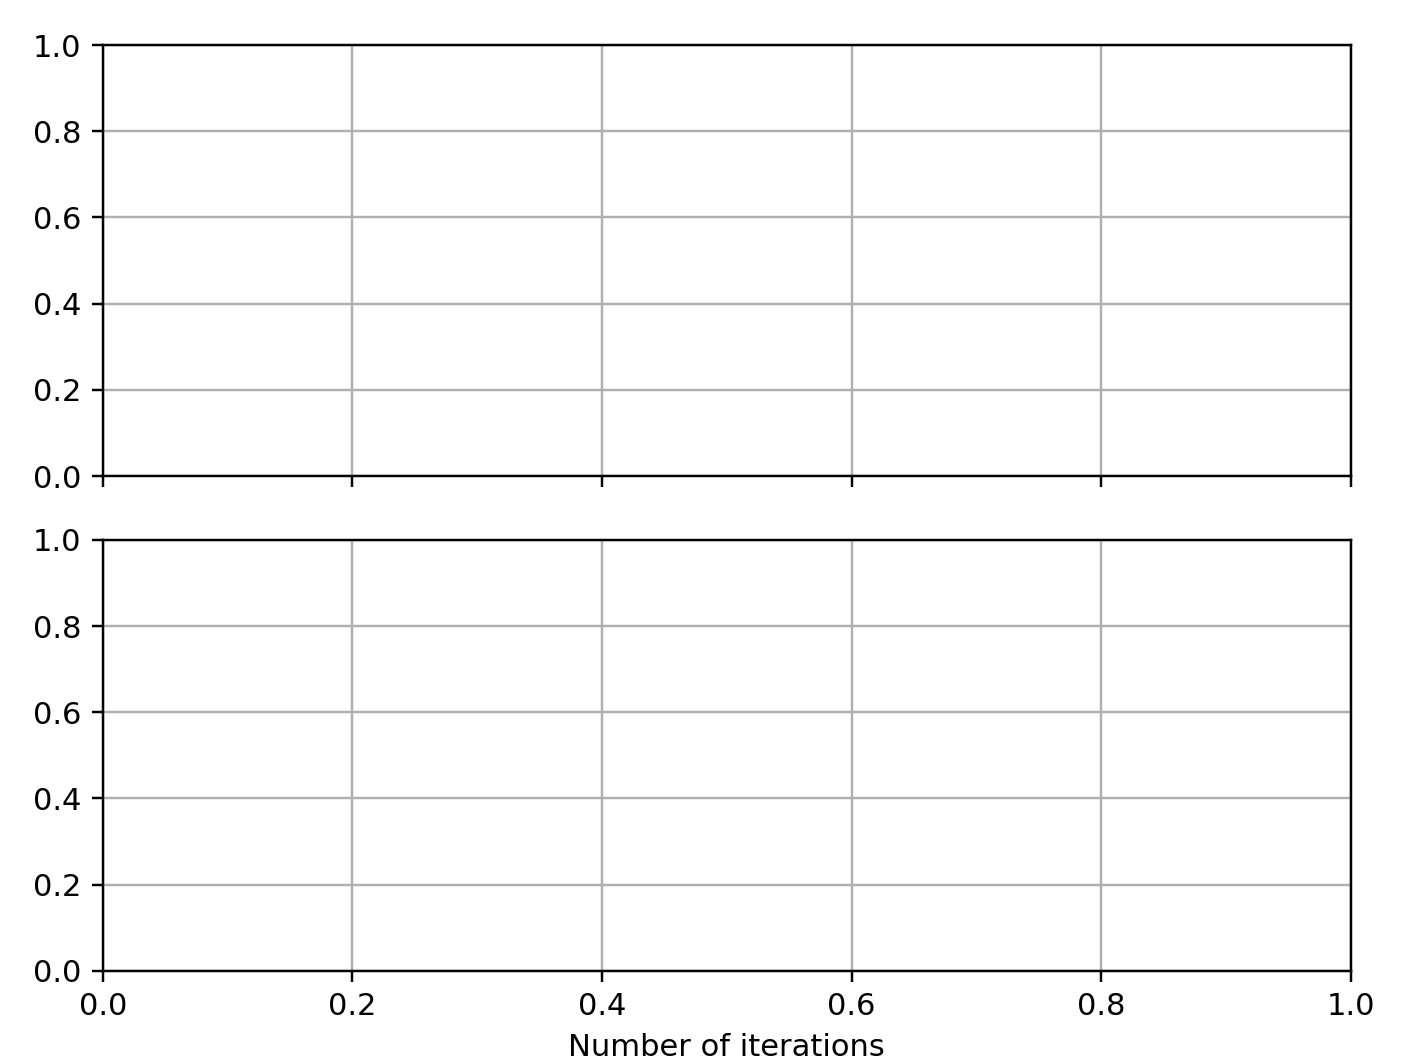

In [10]:
model = NN([518,200,200,8])
from liveplot import create_plot
%matplotlib notebook
plotter, fix, ax = create_plot({'loss':None, 'acc':None}, 3)

In [161]:
from mynn.optimizers.sgd import SGD
from mynn.losses.cross_entropy import softmax_cross_entropy
optim = SGD(model.parameters, learning_rate=0.01, weight_decay=5e-5, momentum=0.8)
batch_size = 50
for i in range(300):
    ''' Train the model for one epoch. '''
    idxs = np.arange(len(train_x)) # randomize our batches
    np.random.shuffle(idxs)
    
    for batch in range(0, len(train_x), batch_size):
        batch_data = train_x[idxs[batch:batch+batch_size]]
        batch_labels = train_y[idxs[batch:batch+batch_size]]
        outs = model(batch_data)                         # get the model output
        #print(outs)
        loss = softmax_cross_entropy(outs, batch_labels) # compute the loss
        loss.backward()                                  # backpropagate
        #print(model.parameters[0].grad)
        optim.step()                                     # optimize the model
        loss.null_gradients()                            # clear the gradient
        
        # keep track of training statistics
        correct = (outs.data.argmax(axis=1) == batch_labels).sum()
        plotter.set_train_batch({'loss': loss.data, 'acc': correct / len(outs)}, len(outs))
    
    idxs = np.arange(len(test_x)) # randomize our batches
    np.random.shuffle(idxs)
    for batch in range(0, len(test_x), batch_size):
        batch_data = test_x[idxs[batch:batch+batch_size]]
        batch_labels = test_y[idxs[batch:batch+batch_size]]
        outs = model(batch_data)
        
        correct = (outs.data.argmax(axis=1) == batch_labels).sum()
        plotter.set_test_batch({'acc': correct/len(outs)}, len(outs))
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()

KeyboardInterrupt: 

In [11]:
import pickle

In [171]:
# dumping model
with open("genre_model", "wb") as f:
    pickle.dump(model.parameters,f)
with open("genre_model_aux", "wb") as f:
    np.savez(f, std=std, mean=mean)